In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append('/home/hxcai/cell_type_specific_CRE')
from MPRA_exp.utils import *

import warnings
warnings.filterwarnings("ignore", category=pd.errors.PerformanceWarning)

In [2]:
# info_df = pd.read_csv('./data/enformer_info.csv')
# info_df = info_df.replace('-', '', regex=True)
# info_df

info_df = pd.read_csv('./data/sei_info.csv')
info_df['cell_type'] = info_df['cell_type'].replace('-', '', regex=True) # SK-N-SH -> SKNSH
info_df

,cell_type,assay,ID,part
0,HeLa_Epithelium_Cervix,BTAF1,ID:1,0
1,H9_Embryonic_Stem_Cell_Embryo,EOMES,ID:1006,0
2,H9_Embryonic_Stem_Cell_Embryo,EP300,ID:1007,0
3,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1010,0
4,H9_Embryonic_Stem_Cell_Embryo,FOXH1,ID:1011,0
...,...,...,...,...
21902,WERIRb1,CTCF,ENCODE,0
21903,WERIRb1,DNase,ENCODE,0
21904,WI38,CTCF,ENCODE,0
21905,WI38 (4OHTAM_20nM_72hr),DNase,ENCODE,0


In [3]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def logit(x):
    return np.log(x/(1-x))


def find_indice(info_df, cell_type='', assay=''):
    mask = info_df['cell_type'].str.contains(cell_type, case=False) & info_df['assay'].str.contains(assay, case=False)
    indice = info_df[mask].index
    print(f'{cell_type} {assay} {len(indice)} data found.')
    
    return indice


def find_indice_precise(info_df, cell_types=[], assays=[]):
    if not cell_types and not assays:
        print('both cell_types and assays are empty, return all indices.')
        return info_df.index
    # Create masks based on the provided criteria
    cell_type_mask = info_df['cell_type'].isin(cell_types) if cell_types else True
    assay_mask = info_df['assay'].isin(assays) if assays else True

    # Combine masks
    mask = cell_type_mask & assay_mask
    indice = info_df[mask].index

    print(f'{cell_types} {assays} {len(indice)} data found.')

    return indice


def compute_pred(main_df, info_df, pred_array, cell_type, assay):
    filtered_indice = find_indice(info_df, cell_type, assay)
    if len(filtered_indice) == 0:
        return

    print(info_df.iloc[filtered_indice])
    for i in filtered_indice:
        print(f'pearson r between true and {i} = {pearsonr(main_df[cell_type], pred_array[:, i])}')
    # for i in filtered_indice:
    #     print(f'pearson r between encode and {i} = {pearsonr(Gosai_designed_sei_pred[:, i], Gosai_designed_sei_pred[:, i])}')
    main_df[f'{cell_type}_{assay}_pred'] = pred_array[:, filtered_indice].mean(axis=1)
    # main_df[f'{cell_type}_{assay}_pred_logit'] = logit(main_df[f'{cell_type}_{assay}_pred'])

    return pred_array[:, filtered_indice].mean(axis=1)


def plot(main_df, cell_type, assay):
    x = main_df[f'{cell_type}_{assay}_pred']
    y = main_df[cell_type]
    r = pearsonr(x, y)[0]
    print(f'pearson r = {r:.3f}')

    fig, ax = plt.subplots(figsize=(8, 6), dpi=50)
    left, right, bottom, top = 0.13, 0.93, 0.15, 0.95
    ax.set_position([left, bottom, right - left, top - bottom])
    sns.scatterplot(x=x, y=y, s=1, edgecolor=None, ax=ax)
    ax.set_xlabel(f'{cell_type}_{assay}_pred')
    ax.set_ylabel(f'{cell_type}_MPRA_true')
    ax.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=ax.transAxes, fontsize=16)
    plt.savefig(f'figures/{cell_type}_{assay}_pred.png', dpi=200)


def plot_logit(main_df, cell_type, assay):
    x = logit(main_df[f'{cell_type}_{assay}_pred'])
    y = main_df[cell_type]
    r = pearsonr(x, y)[0]
    print(f'pearson r = {r:.3f}')

    plot_scatter(x, y, 
                 xlabel=f'{cell_type}_{assay}_pred_logit', 
                 ylabel=f'{cell_type}_MPRA_true', 
                 text=f'pearson r = {r:.3f}', 
                 title=f'', 
                 filename=f'{cell_type}_{assay}_pred_logit')

    # fig, ax = plt.subplots(figsize=(8, 6), dpi=50)
    # left, right, bottom, top = 0.13, 0.93, 0.15, 0.95
    # ax.set_position([left, bottom, right - left, top - bottom])
    # sns.scatterplot(x=x, y=y, s=1, edgecolor=None, ax=ax)
    # ax.set_xlabel(f'{cell_type}_{assay}_pred_logit')
    # ax.set_ylabel(f'{cell_type}_MPRA_true')
    # ax.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=ax.transAxes, fontsize=16)
    # plt.savefig(f'figures/{cell_type}_{assay}_pred_logit.png', dpi=200)

    # plt.figure(figsize=(8, 6), dpi=50)
    # sns.scatterplot(x=x, y=y, s=1, edgecolor=None)
    # plt.xlabel(f'{cell_type}_{assay}_pred_logit')
    # plt.ylabel(f'{cell_type}_MPRA_true')
    # plt.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=plt.gca().transAxes, fontsize=16)
    # plt.savefig(f'figures/{cell_type}_{assay}_pred_logit.png', dpi=300, bbox_inches='tight')


def plot_scatter(x, y, xlabel='', ylabel='', text='', title='', filename=''):
    fig, ax = plt.subplots(figsize=(8, 6), dpi=50)
    left, right, bottom, top = 0.13, 0.93, 0.15, 0.95
    ax.set_position([left, bottom, right - left, top - bottom])
    sns.scatterplot(x=x, y=y, s=1, edgecolor=None, ax=ax)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.text(x=0.1, y=0.9, s=text, transform=ax.transAxes, fontsize=16)
    plt.title(title)
    plt.savefig(f'figures/{filename}.png', dpi=200)


def plot_logit_diff(main_df, cell_type1, cell_type2, assay):
    x = logit(main_df[f'{cell_type1}_{assay}_pred']) - logit(main_df[f'{cell_type2}_{assay}_pred'])
    y = main_df[cell_type1] - main_df[cell_type2]

    r = pearsonr(x, y)[0]
    print(f'pearson r = {r:.3f}')

    fig, ax = plt.subplots(figsize=(8, 6), dpi=50)
    left, right, bottom, top = 0.13, 0.93, 0.15, 0.95
    ax.set_position([left, bottom, right - left, top - bottom])
    sns.scatterplot(x=x, y=y, s=1, edgecolor=None, ax=ax)
    ax.set_xlabel(f'{cell_type1}_{cell_type2}_{assay}_pred_logit_diff')
    ax.set_ylabel(f'{cell_type1}_{cell_type2}_MPRA_true_diff')
    ax.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=ax.transAxes, fontsize=16)
    plt.savefig(f'figures/{cell_type1}_{cell_type2}_{assay}_pred_logit_diff.png', dpi=200)

In [4]:
# Sei_pred = np.concatenate([np.load('data/GosaiMPRA/Gosai_sei_pred_float16.npy'), np.load('data/GosaiMPRA/Gosai_designed_sei_pred.npy')])
# print(Sei_pred.shape)

# main_df = pd.read_csv('/home/hxcai/cell_type_specific_CRE/data/GosaiMPRA/GosaiMPRA_all.csv', sep=',')
# print(main_df.shape)

In [5]:
Sei_pred = np.concatenate([np.load('data/GosaiMPRA/Gosai_sei_pred_0.npy'), np.load('data/GosaiMPRA/Gosai_designed_sei_pred.npy')])
print(Sei_pred.shape)

# Sei_pred = np.load('data/GosaiMPRA/Gosai_designed_sei_pred.npy')
# print(Sei_pred.shape)

# main_df = pd.read_csv('/home/hxcai/cell_type_specific_CRE/data/GosaiMPRA/GosaiMPRA_designed.csv')
# print(main_df.shape)

# Sei_pred = np.load('data/AgarwalMPRA/sei_joint_pred.npy')
# print(Sei_pred.shape)

# main_df = pd.read_csv('../data/AgarwalMPRA/joint_table.csv')
# print(main_df.shape)

(458009, 21907)


In [6]:
main_df = pd.read_csv('/home/hxcai/cell_type_specific_CRE/data/GosaiMPRA/GosaiMPRA_total.csv')
main_df = pd.concat([main_df[:381841], main_df[763683:]])
print(main_df.shape)

(458009, 6)


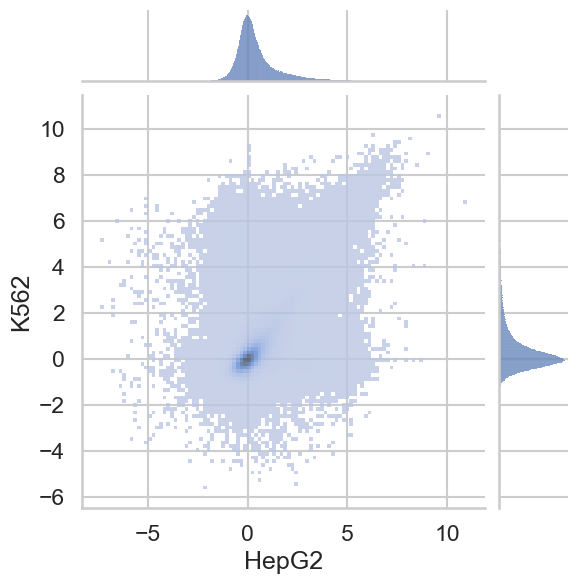

In [7]:
g = sns.jointplot(x=main_df['HepG2'], y=main_df['K562'], kind='hist', bins=100, alpha=0.8)

In [8]:
main_df

,seq,chr,HepG2,K562,SKNSH,origin
0,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,chr7,0.233601,0.060779,0.047194,chr
1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,chr1,0.004565,0.379639,-0.244395,chr
2,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,chr1,0.384537,0.036707,-0.004578,chr
3,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,chr15,4.116494,4.508784,3.040183,chr
4,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,chr12,1.423444,1.616602,1.335892,chr
...,...,...,...,...,...,...
839846,CTCGGAGTTCAAGAAAATCATCTCACACGGCCGTCTCAGACCCTTC...,chr0,0.591628,-0.315267,0.068697,control
839847,GCAATCCTACCCAGACAGATGCAGACAGCGACCTGGTGGGGGATGT...,chr0,-0.359782,-0.134821,-0.022281,control
839848,CCTATGCTGCCTCCTATGCCCTTGTCATCATTGCCATTTTTGAGCT...,chr0,0.489900,0.646673,0.462366,control
839849,AGCCACAACAAAACAGCCAGTTAATGTGGAAACAAGGTCGACAACT...,chr0,-0.014411,-0.061676,0.239693,control


In [5]:
# # 降采样，选择平均表达>1的样本和等量其他样本
# condition_1 = (main_df[['HepG2', 'K562', 'SKNSH']].mean(axis=1) > 1)
# index_1 = main_df[condition_1].index
# np.random.seed(42)
# index_2 = np.random.choice(main_df[~condition_1].index, size=len(index_1), replace=False)
# selected_index = np.concatenate([index_1, index_2])


# Sei_pred = Sei_pred[selected_index]
# main_df = main_df.loc[selected_index]

# g = sns.jointplot(x=main_df['HepG2'], y=main_df['K562'], kind='hist', bins=100, alpha=0.8)

# main_df

In [54]:
import re

# 定义所有可能的别名
aliases = [
    r"hepg2",
    r"hepatocellular[_\s-]*carcinoma",
    r"hep[_\s-]*g[_\s-]*2",
]
aliases = [
    r"K[-\s_]*562",
]
aliases = [
    r"neuroblastoma",
    r"SKNSH",
]
# aliases = [
#     r"WTC11",
#     r"iPSC",
#     r"iPS",
# ]
# aliases = [
#     r"A549",
# ]
# aliases = [
#     r"HCT116",
# ]


# 不区分大小写
pattern = re.compile("|".join(aliases), re.IGNORECASE)
matched_indice = [i for i in range(len(info_df)) if pattern.search(info_df.iloc[i]['cell_type'])]
matched_names = info_df.iloc[matched_indice]['cell_type']
# matched_names = [name for name in info_df['cell_type'] if pattern.search(name)]
matched_names = list(set(matched_names))
# print(matched_names)
# for i in matched_indice:
#     print(info_df.iloc[i])
pd.set_option('display.max_rows', None)
print(info_df.iloc[matched_indice])

for name in matched_names:
    indice = (info_df['cell_type'] == name)
    print(name, indice.sum())

                                    cell_type      assay        ID  part
2916                    SKNSH_RA_Neuron_Brain      DNase  ID:40601     0
4679                    SKNSH_RA_Neuron_Brain      DNase  ID:45067     0
4680                    SKNSH_RA_Neuron_Brain      DNase  ID:45068     0
5066                    SKNSH_RA_Neuron_Brain   H3K27me3  ID:45541     0
5067                    SKNSH_RA_Neuron_Brain   H3K36me3  ID:45542     0
5068                    SKNSH_RA_Neuron_Brain    H3K4me3  ID:45543     0
5544           SKNSH_Neuroblastoma_cell_Brain       NRF1  ID:46034     0
5545           SKNSH_Neuroblastoma_cell_Brain       CTCF  ID:46035     0
5546           SKNSH_Neuroblastoma_cell_Brain       JUND  ID:46036     0
5547           SKNSH_Neuroblastoma_cell_Brain       RFX5  ID:46037     0
5548           SKNSH_Neuroblastoma_cell_Brain       MXI1  ID:46038     0
5549           SKNSH_Neuroblastoma_cell_Brain      EP300  ID:46039     0
5550           SKNSH_Neuroblastoma_cell_Brain      

In [56]:
aliases = [
    r"neuroblastoma",
    r"SKNSH",
]

assays = [
    'DNase',
    'H3K4me3',
    'H3K4me1',
    'H3K9me3',
    'H3K27me3',
    'H3K27ac',
    'H3K36me3',]

# 不区分大小写
pattern = re.compile("|".join(aliases), re.IGNORECASE)
matched_indice = [i for i in range(len(info_df)) if (pattern.search(info_df.iloc[i]['cell_type'])) and (info_df.iloc[i]['assay'] in assays)]
matched_names = info_df.iloc[matched_indice]['cell_type']
# matched_names = [name for name in info_df['cell_type'] if pattern.search(name)]
matched_names = list(set(matched_names))
# print(matched_names)
# for i in matched_indice:
#     print(info_df.iloc[i])
pd.set_option('display.max_rows', None)
print(info_df.iloc[matched_indice])

# for name in matched_names:
#     indice = (info_df['cell_type'] == name)
#     print(name, indice.sum())

                                    cell_type     assay        ID  part
2916                    SKNSH_RA_Neuron_Brain     DNase  ID:40601     0
4679                    SKNSH_RA_Neuron_Brain     DNase  ID:45067     0
4680                    SKNSH_RA_Neuron_Brain     DNase  ID:45068     0
5066                    SKNSH_RA_Neuron_Brain  H3K27me3  ID:45541     0
5067                    SKNSH_RA_Neuron_Brain  H3K36me3  ID:45542     0
5068                    SKNSH_RA_Neuron_Brain   H3K4me3  ID:45543     0
7304              Neuroblastoma_patient_cells   H3K27ac  ID:50618     0
7305              Neuroblastoma_patient_cells   H3K27ac  ID:50619     0
7306              Neuroblastoma_patient_cells   H3K27ac  ID:50621     0
10605               NB1643_Neuroblastoma_cell   H3K27ac  ID:62263     0
10619                      Neuroblastoma_cell   H3K27ac  ID:62282     0
10621                      Neuroblastoma_cell   H3K27ac  ID:62284     0
10622                      Neuroblastoma_cell   H3K27ac  ID:6228

In [39]:
# define correct cell type names
# cell_types_possible_dict = {
#     'HepG2': ['HepG2', 'HepG2_Epithelium_Liver', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_hepatocellular_carcinoma'],
#     'K562' : ['K562', 'K562_Leukemia_Bone', 'K562_Leukemia_Cell', 'K562_Leukemia', 'K562_Lymphoblast', 'K562_human_erythroleukemic_cell_line', 'K562_Haematopoietic_and_lymphoid'],
#     'SKNSH': ['SKNSH', 'SKNSH_Neuroblastoma_cell_Brain'],
#     'WTC11': ['WTC11', 'iPSC'],
# }

# 不一定全，但是都是常用名
cell_types_possible_names_dict = {
    'HepG2': ['HepG2', 'HepG2_Epithelium_Liver'],
    'K562' : ['K562', 'K562_Erythroblast_Bone_Marrow'],
    'SKNSH': ['SKNSH', 'SKNSH_Neuroblastoma_cell_Brain', 'Neuroblastoma_cell', 'SHEP21N_Neuroblastoma_cell_Bone_Marrow'],
    'WTC11': ['iPSC'],
    'A549' : ['A549_Epithelium_Lung'],
    'HCT116': ['HCT116_Colon_cancer_cell_Colon', 'HCT116_HCT116', 'HCT116_Colon'],
}

In [47]:
assays = [
    'DNase',
    'H3K4me3',
    'H3K4me1',
    'H3K9me3',
    'H3K27me3',
    'H3K27ac',
    'H3K36me3',]

for assay in assays:
    indice = [i for i in range(len(info_df)) if (pattern.search(info_df.iloc[i]['cell_type']) and (assay == info_df.iloc[i]['assay']))]
    print(info_df.iloc[indice])

                          cell_type  assay        ID  part
2916          SKNSH_RA_Neuron_Brain  DNase  ID:40601     0
4679          SKNSH_RA_Neuron_Brain  DNase  ID:45067     0
4680          SKNSH_RA_Neuron_Brain  DNase  ID:45068     0
16705  SKNBE(2)c_Neuroblastoma_cell  DNase  ID:78824     0
21842                      SKNSH_RA  DNase    ENCODE     0
                                    cell_type    assay        ID  part
5068                    SKNSH_RA_Neuron_Brain  H3K4me3  ID:45543     0
12382          SKNSH_Neuroblastoma_cell_Brain  H3K4me3  ID:65004     0
12383          SKNSH_Neuroblastoma_cell_Brain  H3K4me3  ID:65005     0
13631          SKNSH_Neuroblastoma_cell_Brain  H3K4me3  ID:67697     0
14566              IMR5_75_Neuroblastoma_cell  H3K4me3  ID:70716     0
14569                      Neuroblastoma_cell  H3K4me3  ID:70719     0
14572                      Neuroblastoma_cell  H3K4me3  ID:70723     0
14575               SHSY5Y_Neuroblastoma_cell  H3K4me3  ID:70727     0
14577  

In [40]:
# cell_types = ['HepG2', 'K562', 'SKNSH']
# cell_types = ['HepG2', 'K562']

# ENCODE上最常见的6种组蛋白修饰
assays = [
    'DNase',
    'H3K4me3',
    'H3K4me1',
    'H3K9me3',
    'H3K27me3',
    'H3K27ac',
    'H3K36me3',]

for cell_type, cell_names in cell_types_possible_names_dict.items():
    for assay in assays:
        indice = find_indice_precise(info_df, cell_types=cell_names, assays=[assay])

['HepG2', 'HepG2_Epithelium_Liver'] ['DNase'] 8 data found.
['HepG2', 'HepG2_Epithelium_Liver'] ['H3K4me3'] 7 data found.
['HepG2', 'HepG2_Epithelium_Liver'] ['H3K4me1'] 3 data found.
['HepG2', 'HepG2_Epithelium_Liver'] ['H3K9me3'] 1 data found.
['HepG2', 'HepG2_Epithelium_Liver'] ['H3K27me3'] 1 data found.
['HepG2', 'HepG2_Epithelium_Liver'] ['H3K27ac'] 8 data found.
['HepG2', 'HepG2_Epithelium_Liver'] ['H3K36me3'] 2 data found.
['K562'] ['DNase'] 2 data found.
['K562'] ['H3K4me3'] 1 data found.
['K562'] ['H3K4me1'] 1 data found.
['K562'] ['H3K9me3'] 1 data found.
['K562'] ['H3K27me3'] 1 data found.
['K562'] ['H3K27ac'] 1 data found.
['K562'] ['H3K36me3'] 1 data found.
['SKNSH', 'SKNSH_Neuroblastoma_cell_Brain', 'Neuroblastoma_cell', 'SHEP21N_Neuroblastoma_cell_Bone_Marrow'] ['DNase'] 0 data found.
['SKNSH', 'SKNSH_Neuroblastoma_cell_Brain', 'Neuroblastoma_cell', 'SHEP21N_Neuroblastoma_cell_Bone_Marrow'] ['H3K4me3'] 9 data found.
['SKNSH', 'SKNSH_Neuroblastoma_cell_Brain', 'Neuroblast

In [30]:
# # find intersect assays
# cell_type_specific_assays_list = []
# for cell_type in cell_types:
#     indice = find_indice_precise(info_df, cell_types=cell_types_possible_dict[cell_type], assays=[])
#     unique_assays = set(info_df.iloc[indice]['assay'])
#     print(f'{cell_type} {len(unique_assays)} unique assays')
#     cell_type_specific_assays_list.append(unique_assays)

# intersect_assays = list(set.intersection(*cell_type_specific_assays_list))
# print(f'{len(intersect_assays)} intersect assays found.')
# save_txt('data/intersect_assays.txt', intersect_assays)

# # compute SEI prediction for each cell type and assay
# assays = load_txt('data/intersect_assays.txt')

for cell_type in cell_types:
    for assay in assays:
        indice = find_indice_precise(info_df, cell_types=cell_types_possible_dict[cell_type], assays=[assay])
        value = Sei_pred[:, indice].mean(axis=1)
        main_df[f'{cell_type}_{assay}_pred'] = value
        main_df[f'{cell_type}_{assay}_pred_logit'] = logit(value)
main_df = main_df.copy()

['HepG2', 'HepG2_Epithelium_Liver'] ['DNase'] 8 data found.


NameError: name 'Sei_pred' is not defined

In [54]:
main_df

,seq,chr,HepG2,K562,SKNSH,origin,HepG2_DNase_pred,HepG2_DNase_pred_logit,HepG2_H3K4me3_pred,HepG2_H3K4me3_pred_logit,...,K562_H3K4me1_pred,K562_H3K4me1_pred_logit,K562_H3K9me3_pred,K562_H3K9me3_pred_logit,K562_H3K27me3_pred,K562_H3K27me3_pred_logit,K562_H3K27ac_pred,K562_H3K27ac_pred_logit,K562_H3K36me3_pred,K562_H3K36me3_pred_logit
0,CCTGGTCTTTCTTGCTAAATAAACATATCGTGCATCATCCAGATCT...,chr7,0.233601,0.060779,0.047194,chr,0.000912,-6.998883,0.000245,-8.314024,...,0.001145,-6.771311,0.001413,-6.560611,0.001139,-6.776175,0.000398,-7.827578,0.002537,-5.974298
1,CATAAAGATGAGGCTTGGCAAAGAACATCTCTCGGTGCCTCCCATT...,chr1,0.004565,0.379639,-0.244395,chr,0.001802,-6.317000,0.000314,-8.064404,...,0.003455,-5.664538,0.002008,-6.208771,0.002054,-6.186030,0.000605,-7.410352,0.002568,-5.962047
2,CATAAAGCCAATCACTGAGATGACAAGTACTGCCAGGAAAGAAGGC...,chr1,0.384537,0.036707,-0.004578,chr,0.002067,-6.179717,0.000482,-7.636459,...,0.007365,-4.903593,0.002881,-5.846780,0.001299,-6.644996,0.001187,-6.735343,0.003239,-5.729329
3,CATAAAGGCAGTGTAGACCCAAACAGTGAGCAGTAGCAAGATTTAT...,chr15,4.116494,4.508784,3.040183,chr,0.002578,-5.958029,0.013974,-4.256457,...,0.015827,-4.130083,0.014548,-4.215643,0.000713,-7.245694,0.004746,-5.345765,0.003503,-5.650508
4,CATAAAGGGCTGAACATGCTGTTGAAAAAATGTAGATATAAAAGTT...,chr12,1.423444,1.616602,1.335892,chr,0.000129,-8.957862,0.000052,-9.871470,...,0.000020,-10.823502,0.000348,-7.963574,0.000144,-8.848699,0.000065,-9.634954,0.000489,-7.621811
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
839846,CTCGGAGTTCAAGAAAATCATCTCACACGGCCGTCTCAGACCCTTC...,chr0,0.591628,-0.315267,0.068697,control,0.002228,-6.104423,0.000661,-7.320609,...,0.001479,-6.515214,0.002383,-6.037018,0.003070,-5.782842,0.000467,-7.668702,0.003925,-5.536457
839847,GCAATCCTACCCAGACAGATGCAGACAGCGACCTGGTGGGGGATGT...,chr0,-0.359782,-0.134821,-0.022281,control,0.001449,-6.535301,0.000066,-9.624218,...,0.001967,-6.229310,0.002998,-5.806968,0.002579,-5.957690,0.000298,-8.117705,0.003312,-5.706948
839848,CCTATGCTGCCTCCTATGCCCTTGTCATCATTGCCATTTTTGAGCT...,chr0,0.489900,0.646673,0.462366,control,0.000679,-7.294450,0.000124,-8.995004,...,0.000488,-7.625328,0.001592,-6.441371,0.000628,-7.372484,0.000167,-8.699901,0.001956,-6.235082
839849,AGCCACAACAAAACAGCCAGTTAATGTGGAAACAAGGTCGACAACT...,chr0,-0.014411,-0.061676,0.239693,control,0.001426,-6.551234,0.000819,-7.106508,...,0.002473,-5.999901,0.001970,-6.227694,0.001491,-6.506579,0.000743,-7.204312,0.003686,-5.599554


In [55]:
for cell_type in cell_types:
    for assay in assays:
        # indice = find_indice_precise(info_df, cell_types_possible_dict[cell_type], [assay])
        # value = Gosai_designed_sei_pred[:, indice].mean(axis=1)
        # main_df[f'{cell_type}_{assay}_pred'] = value
        print(f'{cell_type}_{assay}_pred mean = {main_df[f"{cell_type}_{assay}_pred"].mean()}')
        # plot_logit(main_df, cell_type, assay)

HepG2_DNase_pred mean = 0.021541481837630272
HepG2_H3K4me3_pred mean = 0.004384274128824472
HepG2_H3K4me1_pred mean = 0.0026674973778426647
HepG2_H3K9me3_pred mean = 0.014417548663914204
HepG2_H3K27me3_pred mean = 0.0035881493240594864
HepG2_H3K27ac_pred mean = 0.002353447023779154
HepG2_H3K36me3_pred mean = 0.0005244227941147983
K562_DNase_pred mean = 0.03521432355046272
K562_H3K4me3_pred mean = 0.01036170031875372
K562_H3K4me1_pred mean = 0.007431530859321356
K562_H3K9me3_pred mean = 0.0042116171680390835
K562_H3K27me3_pred mean = 0.0025939547922462225
K562_H3K27ac_pred mean = 0.00953903328627348
K562_H3K36me3_pred mean = 0.002334748161956668


In [56]:
# cell_type = 'HepG2'
# assay = 'DNase'
for assay in assays:
    for cell_type in cell_types:
        indice = find_indice_precise(info_df, cell_types_possible_dict[cell_type], [assay])
        value = Sei_pred[:, indice].mean(axis=1)
        main_df[f'{cell_type}_{assay}_pred'] = value
        print(f'{cell_type}_{assay}_pred mean = {value.mean()}')
        # plot_logit(main_df, cell_type, assay)
        x = logit(main_df[f'{cell_type}_{assay}_pred'])
        y = main_df[cell_type]
        r = pearsonr(x, y)[0]
        print(f'pearson r = {r:.3f}')

['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['DNase'] 9 data found.
HepG2_DNase_pred mean = 0.021541481837630272
pearson r = 0.493
['K562', 'K562_Leukemia_Bone', 'K562_Leukemia_Cell', 'K562_Leukemia', 'K562_Lymphoblast', 'K562_human_erythroleukemic_cell_line', 'K562_Haematopoietic_and_lymphoid'] ['DNase'] 2 data found.
K562_DNase_pred mean = 0.03521432355046272
pearson r = 0.566
['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['H3K4me3'] 8 data found.
HepG2_H3K4me3_pred mean = 0.004384274128824472
pearson r = 0.490
['K562', 'K562_Leukemia_Bone', 'K562_Leukemia_Cell', 'K562_Leukemia', 'K562_Lymphoblast', 'K562_human_erythroleukemic_cell_line', 'K562_Haematopoietic_and_lymphoid'] ['H3K4me3'] 1 data found.
K562_H3K4me3_pred mean = 0.01036170031875372
pearson r = 0.525
['HepG2', 'HepG2_Hepatocellular_Carcinoma', 'HepG2_Epithelium_Liver', 'HepG2_hepatocellular_carcinoma'] ['H3

In [57]:
# cell_type_specific_assays_list = []

# for cell_type in ['HepG2', 'K562', 'SKNSH']:
#     indice = find_indice(info_df, cell_type, '')
#     assays = set(info_df.iloc[indice]['assay'])
#     cell_type_specific_assays_list.append(assays)

# intersect_assays = list(set.intersection(*cell_type_specific_assays_list))
# print(len(intersect_assays))

# save_txt('data/intersect_assays.txt', intersect_assays)

# cell_types = ['HepG2', 'K562', 'SKNSH']
# assays = load_txt('data/sei_intersect_assays.txt')

# for cell_type in cell_types:
#     for assay in assays:
#         compute_pred(main_df, info_df, Gosai_designed_sei_pred, cell_type, assay)

In [58]:
cell_type_columns_dict = {}
for cell_type in cell_types:
    cell_type_columns_dict[cell_type] = [f'{cell_type}_{assay}_pred_logit' for assay in assays]

# data_split_column = 'origin'
# data_split_dict = {
#     'train': ['control', 'DHS_natural', 'Malinois_natural'],
#     'valid': ['AdaLead', 'FastSeqProp', 'Simulated_Annealing'],
# }

data_split_column = 'chr'
data_split_dict = {
    'train': ['chr'+str(i) for i in range(3,23)],
    'valid': ['chr1'],
    'test': ['chr2'],
    'designed': ['chr0'],
}

In [60]:
from sklearn.linear_model import LinearRegression, Lasso

for cell_type in cell_types:
    # train
    data_split = 'train'
    print(f'train model by {cell_type} {data_split} data')
    df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
    X_train = np.array(df[cell_type_columns_dict[cell_type]])
    y_train = np.array(df[cell_type])

    # model = LinearRegression()
    model = Lasso(alpha=1e-2)
    model.fit(X_train, y_train)

    # valid
    for cell_type in cell_types:
        for data_split in ['train', 'valid', 'test', 'designed']:
            df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
            X_valid = np.array(df[cell_type_columns_dict[cell_type]])
            y_valid = np.array(df[cell_type])
            y_pred = model.predict(X_valid)
            r = pearsonr(y_valid, y_pred)[0]
            print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")
    print()

train model by HepG2 train data
HepG2 train Pearson's r: 0.546
HepG2 valid Pearson's r: 0.530
HepG2 test Pearson's r: 0.515
HepG2 designed Pearson's r: 0.667
K562 train Pearson's r: 0.562
K562 valid Pearson's r: 0.540
K562 test Pearson's r: 0.530
K562 designed Pearson's r: 0.782

train model by K562 train data
HepG2 train Pearson's r: 0.508
HepG2 valid Pearson's r: 0.487
HepG2 test Pearson's r: 0.475
HepG2 designed Pearson's r: 0.703
K562 train Pearson's r: 0.603
K562 valid Pearson's r: 0.581
K562 test Pearson's r: 0.574
K562 designed Pearson's r: 0.801



In [61]:
top_coef_index = np.abs(model.coef_).argsort()[::-1][:10]

for i in top_coef_index:
    print(assays[i], model.coef_[i])

H3K27me3 -0.57164574
DNase 0.4228963
H3K4me3 0.30656844
H3K9me3 0.169618
H3K36me3 -0.16624808
H3K27ac -0.0
H3K4me1 -0.0


In [55]:
for cell_type1, cell_type2 in [('HepG2', 'K562'), ('HepG2', 'WTC11'), ('K562', 'WTC11')]:

    # cell_type1 = 'HepG2'
    data_split = 'train'
    df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
    X_train1 = np.array(df[cell_type_columns_dict[cell_type1]])
    y_train1 = np.array(df[cell_type1])

    # cell_type2 = 'K562'
    data_split = 'train'
    df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
    X_train2 = np.array(df[cell_type_columns_dict[cell_type2]])
    y_train2 = np.array(df[cell_type2])

    X_train = np.concatenate([X_train1, X_train2])
    y_train = np.concatenate([y_train1, y_train2])


    model = Lasso(alpha=0.01)
    model.fit(X_train, y_train)

    # train set, same seq and cell type

    for cell_type in cell_types:
        for data_split in ['train', 'valid']:
            df = main_df[main_df[data_split_column].isin(data_split_dict[data_split])]
            X_valid = np.array(df[cell_type_columns_dict[cell_type]])
            y_valid = np.array(df[cell_type])
            y_pred = model.predict(X_valid)
            r = pearsonr(y_valid, y_pred)[0]
            print(f"{cell_type} {data_split} Pearson's r: {r:.3f}")

HepG2 train Pearson's r: 0.498
HepG2 valid Pearson's r: 0.470
K562 train Pearson's r: 0.566
K562 valid Pearson's r: 0.547


KeyError: 'WTC11'

In [27]:
# cell_type = 'HepG2'
# cell_type_2 = 'K562'
# assay = 'Dnase'

# x = main_df[f'{cell_type}_{assay}_pred_logit']
# y = main_df[cell_type_2]
# r = pearsonr(x, y)[0]
# print(f'pearson r = {r:.3f}')

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=x, y=y, s=1, edgecolor=None)
# plt.xlabel(f'{cell_type}_{assay}_pred_logit')
# plt.ylabel(f'{cell_type_2}_MPRA_true')
# plt.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=plt.gca().transAxes, fontsize=16)
# plt.savefig(f'figures/{cell_type}_{assay}_pred_logit_1.png', dpi=300, bbox_inches='tight')

In [28]:
# cell_type = 'K562'
# cell_type_2 = 'HepG2'
# assay = 'Dnase'

# x = main_df[f'{cell_type}_{assay}_pred_logit']
# y = main_df[cell_type_2]
# r = pearsonr(x, y)[0]
# print(f'pearson r = {r:.3f}')

# plt.figure(figsize=(8, 6))
# sns.scatterplot(x=x, y=y, s=1, edgecolor=None)
# plt.xlabel(f'{cell_type}_{assay}_pred_logit')
# plt.ylabel(f'{cell_type_2}_MPRA_true')
# plt.text(x=0.1, y=0.9, s=f'pearson r = {r:.3f}', transform=plt.gca().transAxes, fontsize=16)
# plt.savefig(f'figures/{cell_type}_{assay}_pred_logit_1.png', dpi=300, bbox_inches='tight')

pearson r = 0.330


KeyError: 'SKNSH_DNase_pred'

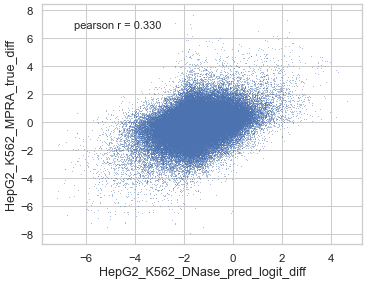

In [29]:
plot_logit_diff(main_df, 'HepG2', 'K562', 'DNase')
# plot_logit_diff(main_df, 'HepG2', 'SKNSH', 'DNase')
# plot_logit_diff(main_df, 'K562', 'SKNSH', 'DNase')